[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ClimateMatchAcademy/course-content/blob/main/tutorials/W1D2_StateoftheClimateOceanandAtmosphereReanalysis/W1D2_Tutorial2.ipynb) &nbsp; <a href="https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/ClimateMatchAcademy/course-content/main/tutorials/W1D2_StateoftheClimateOceanandAtmosphereReanalysis/W1D2_Tutorial2.ipynb" target="_parent"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" alt="Open in Kaggle"/></a>

# **Tutorial 2: A Lot of Weather Makes Climate - Exploring the ERA5 Reanalysis**

**Week 1, Day 2, Ocean-Atmosphere Reanalysis**

__Content creators:__ Momme Hell

**Content reviewers:** Katrina Dobson, Danika Gupta, Maria Gonzalez, Will Gregory, Nahid Hasan, Sherry Mi, Beatriz Cosenza Muralles, Jenna Pearson, Chi Zhang, Ohad Zivan

**Content editors:** Jenna Pearson, Chi Zhang, Ohad Zivan

**Production editors:** Wesley Banfield, Jenna Pearson, Chi Zhang, Ohad Zivan

**Our 2023 Sponsors:** NASA TOPS and Google DeepMind

# Tutorial Objectives

In the previous tutorial, we learned about ENSO, which is a specific atmosphere-ocean dynamical phenomena. You will now examine the atmosphere and the ocean systems more generally.

In this tutorial, you will learn to work with reanalysis data. These data combine observations and models of the Earth system, and are a critical tool for weather and climate science. You will first utilize two methods to access a specific reanalysis dataset (ECMWF's ERA5; through [PO.DAAC](https://podaac.jpl.nasa.gov/) and through the web Copernicus API). You will then select and mask a region of interest, investigating how important climate variables change on medium length timescales (hours to months) within this region.

By the end of this tutorial, you will be able to:
- Access and select reanalysis data of cliamtically-important variables
- Plot maps to explore changes on various time scales.
- Compute and compare timeseries of different variables from reanalysis data.

# Setup

In [1]:
# !pip install pythia_datasets
# !pip install cartopy
# !pip install geoviews

In [2]:
# imports
from intake import open_catalog
import matplotlib.pyplot as plt
import matplotlib
import xarray as xr
import fsspec
import numpy as np

import boto3
import botocore
import datetime
import numpy as np
import os
import pooch
import tempfile
import geoviews as gv
import holoviews
from geoviews import Dataset as gvDataset
import geoviews.feature as gf
from geoviews import Image as gvImage

from cartopy import crs as ccrs
from cartopy import feature as cfeature

# import warnings
# #  Suppress warnings issued by Cartopy when downloading data files
# warnings.filterwarnings('ignore')

In [3]:
# @title Figure Settings
import ipywidgets as widgets  # interactive display

%config InlineBackend.figure_format = 'retina'
plt.style.use(
    "https://raw.githubusercontent.com/ClimateMatchAcademy/course-content/main/cma.mplstyle"
)

In [4]:
# @title Helper functions

def pooch_load(filelocation=None, filename=None, processor=None):
    shared_location = "/home/jovyan/shared/Data/tutorials/W1D2_StateoftheClimateOceanandAtmosphereReanalysis"  # this is different for each day
    user_temp_cache = tempfile.gettempdir()

    if os.path.exists(os.path.join(shared_location, filename)):
        file = os.path.join(shared_location, filename)
    else:
        file = pooch.retrieve(
            filelocation,
            known_hash=None,
            fname=os.path.join(user_temp_cache, filename),
            processor=processor,
        )

    return file

In [5]:
# @title Video 1: ECMWF Reanalysis

from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
  def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
    self.id = id
    if source == 'Bilibili':
      src = f'https://player.bilibili.com/player.html?bvid={id}&page={page}'
    elif source == 'Osf':
      src = f'https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render'
    super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
  tab_contents = []
  for i, video_id in enumerate(video_ids):
    out = widgets.Output()
    with out:
      if video_ids[i][0] == 'Youtube':
        video = YouTubeVideo(id=video_ids[i][1], width=W,
                             height=H, fs=fs, rel=0)
        print(f'Video available at https://youtube.com/watch?v={video.id}')
      else:
        video = PlayVideo(id=video_ids[i][1], source=video_ids[i][0], width=W,
                          height=H, fs=fs, autoplay=False)
        if video_ids[i][0] == 'Bilibili':
          print(f'Video available at https://www.bilibili.com/video/{video.id}')
        elif video_ids[i][0] == 'Osf':
          print(f'Video available at https://osf.io/{video.id}')
      display(video)
    tab_contents.append(out)
  return tab_contents


video_ids = [('Youtube', 'xn_SGxTm6LA'), ('Bilibili', 'BV1g94y1B7Yw')]
tab_contents = display_videos(video_ids, W=730, H=410)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
  tabs.set_title(i, video_ids[i][0])
display(tabs)

# Section 1: What is Reanalysis Data?

**Reanalysis** refers to the process of combining historical observations from a variety of sources, such as weather stations, satellite measurments, and ocean buoys, with numerical models to create a comprehensive and consistent record of past weather and climate conditions. Reanalysis data is a useful tool to examine the Earth's climate system over a wide range of time scales, from seasonal through decadal to century-scale changes. 

There are multiple Earth system reanalysis products (e.g. MERRA-2, NCEP-NCAR, JRA-55C, [see extensive list here](https://climatedataguide.ucar.edu/climate-data/atmospheric-reanalysis-overview-comparison-tables)), and no single product fits all needs. For the purposes of this tutorial you will be using a product from the European Centre for Medium-Range Weather Forecasts (ECMWF) called **ECMWF Reanalysis v5 (ERA5)**. [This video](https://climate.copernicus.eu/climate-reanalysis) from the ECMWF provides you with a brief introduction to the ERA5 product.

## Section 1.1: Accessing ERA5 Data

You will access the data through the an AWS S3 bucket of the data: [ECMWF ERA5 Reanalysis](https://registry.opendata.aws/ecmwf-era5/). To do this you need the name of the bucket "era5-pds", and the file location in the bucket. *Note: you can open the [AWS link](https://registry.opendata.aws/ecmwf-era5/) and find a guided tutorial on how to explore the S3 bucket.*

Let's select a specific year and month to work with, March of 2018:

In [6]:
era5_bucket = "era5-pds"
client = boto3.client(
    "s3", config=botocore.client.Config(signature_version=botocore.UNSIGNED)
)  # initialize aws s3 bucket client
date_sel = datetime.datetime(
    2018, 3, 1, 0
)  # select a desired date and hours (midnight is zero)
prefix = date_sel.strftime("%Y/%m/")  # format the date to match the s3 bucket
metadata_file = "main.nc"  # filename on the s3 bucket
metadata_key = prefix + metadata_file  # file location and name on the s3 bucket
filepath = pooch_load(
    filelocation="http://s3.amazonaws.com/" + era5_bucket + "/" + metadata_key,
    filename=metadata_file,
)  # open the file

ds_meta = xr.open_dataset(filepath)  # open the file
ds_meta

<xarray.Dataset>
Dimensions:                                                                                   (
                                                                                               lat: 721,
                                                                                               time1: 744,
                                                                                               time0: 744,
                                                                                               lon: 1440,
                                                                                               lon_ocean: 720,
                                                                                               lat_ocean: 361,
                                                                                               nv: 2)
Coordinates:
  * lat                                                                                       (lat) float32 ...
  * time1                                                                                     (time1) datetime64[ns] ...
  * time0                                                                                     (time0) datetime64[ns] ...
  * lon                                                                                       (lon) float32 ...
  * lon_ocean                                                                                 (lon_ocean) float32 ...
  * lat_ocean                                                                                 (lat_ocean) float32 ...
Dimensions without coordinates: nv
Data variables: (12/19)
    sea_surface_temperature                                                                   (time0, lat, lon) float32 ...
    sea_surface_wave_mean_period                                                              (time0, lat_ocean, lon_ocean) float32 ...
    air_temperature_at_2_metres_1hour_Maximum                                                 (time1, lat, lon) float32 ...
    dew_point_temperature_at_2_metres                                                         (time0, lat, lon) float32 ...
    significant_height_of_wind_and_swell_waves                                                (time0, lat_ocean, lon_ocean) float32 ...
    sea_surface_wave_from_direction                                                           (time0, lat_ocean, lon_ocean) float32 ...
    ...                                                                                        ...
    lwe_thickness_of_surface_snow_amount                                                      (time0, lat, lon) float32 ...
    snow_density                                                                              (time0, lat, lon) float32 ...
    eastward_wind_at_10_metres                                                                (time0, lat, lon) float32 ...
    integral_wrt_time_of_surface_direct_downwelling_shortwave_flux_in_air_1hour_Accumulation  (time1, lat, lon) float32 ...
    air_temperature_at_2_metres                                                               (time0, lat, lon) float32 ...
    northward_wind_at_10_metres                                                               (time0, lat, lon) float32 ...
Attributes:
    source:       Reanalysis
    institution:  ECMWF
    tilte:        ERA5 forecasts

You just loaded an `xarray` dataset, as introduced at the first day. This dataset contains 19 variables covering the whole globe (-90 to +90 degrees in latitude, 0 to 360 degrees on longitude) along with their respective coordinates. With this dataset you have access to our best estimates of climate parameters with a temporal resolution of 1 hour and a spatial resolution of 1/4 degree (i.e. grid points near the Equator represent a ~25 km x 25 km region). This is a lot of data, but still just a fraction the data available through the [full ERA5 dataset](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-land?tab=overview). 


## Section 1.2: Selecting Regions of Interest
The global ERA5 data over the entire time range is so large that even just one variable would be too large to store on your computer. Here you will apply a method to load a region (i.e., a spatial subset) of the data. In this first example, you will load *air surface temperature at 2 meters* data for a small region in the Northeastern United States. In later tutorials you will have the opportunity to select a region of your choice and to explore other climate variables. 

In [7]:
# the order of the lat lon range has to follow the convention of the data set.
# for this dataset, longitude ranges from 0 to 360 degrees and
# latitude ranges from 90 degrees Northto 90 degrees South .

# northeastern United States
lat_range = [55.2, 30.2]  # from north to south
lon_range = [270, 295]  # from west to east

In [8]:
# note this can take several minutes to download
selected_vars = [
    "air_temperature_at_2_metres",
    "northward_wind_at_10_metres",
    "eastward_wind_at_10_metres",
    "surface_air_pressure",
    "sea_surface_temperature",
]  # the variables we want
s3_data_ptrn = (
    "{year}/{month}/data/{var}.nc"  # path and filename format for this S3 bucket
)
year_s3 = date_sel.strftime("%Y")  # extract the year
month_s3 = date_sel.strftime("%m")  # extract the month
ERA5_select = []  # initialize the dataset, will save a complicated check later
for var in selected_vars:  # this will download 5 files of 500Mb each.
    s3_data_key = s3_data_ptrn.format(
        year=year_s3, month=month_s3, var=var
    )  # variable specific  key
    print("Downloading %s from S3..." % s3_data_key)
    filepath = pooch_load(
        filelocation="http://s3.amazonaws.com/" + era5_bucket + "/" + s3_data_key,
        filename=s3_data_key,
    )  # open the file
    ds_temp = xr.open_dataset(filepath)  # retrieve the variable from the bucket
    if (
        ERA5_select
    ):  # check if the dataset is empty or not (first iteration of the loop)
        ERA5_select = xr.merge(
            [ERA5_select, ds_temp]
        )  # if not empty, merge the new file
    else:
        ERA5_select = ds_temp  # if empty, just assign the new file

ERA5_allvars = ERA5_select.sel(lon=slice(lon_range[0], lon_range[1])).sel(
    lat=slice(lat_range[0], lat_range[1])
)
ERA5_allvars

<xarray.Dataset>
Dimensions:                      (lon: 101, lat: 100, time0: 744)
Coordinates:
  * lon                          (lon) float32 270.0 270.2 270.5 ... 294.8 295.0
  * lat                          (lat) float32 55.0 54.75 54.5 ... 30.5 30.25
  * time0                        (time0) datetime64[ns] 2018-03-01 ... 2018-0...
Data variables:
    air_temperature_at_2_metres  (time0, lat, lon) float32 ...
    northward_wind_at_10_metres  (time0, lat, lon) float32 ...
    eastward_wind_at_10_metres   (time0, lat, lon) float32 ...
    surface_air_pressure         (time0, lat, lon) float32 ...
    sea_surface_temperature      (time0, lat, lon) float32 ...
Attributes:
    source:       Reanalysis
    institution:  ECMWF
    tilte:        ERA5 forecasts

The magnitude of the wind vector represents the wind speed 

\begin{align}
||u|| = \sqrt{u^2 + v^2}
\end{align}

which you will use later in the tutorial and discuss in more detail in tutorial 4. We will calculate that here and add it to our dataset.

In [9]:
# compute ten meter wind speed
ERA5_allvars["wind_speed"] = np.sqrt(
    ERA5_allvars["northward_wind_at_10_metres"] ** 2
    + ERA5_allvars["eastward_wind_at_10_metres"] ** 2
)  # calculate the wind speed from the vectors
# name and units in the DataArray:
ERA5_allvars["wind_speed"].attrs[
    "long_name"
] = "10-meter wind speed"  # assigning long name to the windspeed
ERA5_allvars["wind_speed"].attrs["units"] = "m/s"  # assigning units
ERA5_allvars

<xarray.Dataset>
Dimensions:                      (lon: 101, lat: 100, time0: 744)
Coordinates:
  * lon                          (lon) float32 270.0 270.2 270.5 ... 294.8 295.0
  * lat                          (lat) float32 55.0 54.75 54.5 ... 30.5 30.25
  * time0                        (time0) datetime64[ns] 2018-03-01 ... 2018-0...
Data variables:
    air_temperature_at_2_metres  (time0, lat, lon) float32 ...
    northward_wind_at_10_metres  (time0, lat, lon) float32 2.5 2.312 ... -2.625
    eastward_wind_at_10_metres   (time0, lat, lon) float32 -3.188 ... -3.125
    surface_air_pressure         (time0, lat, lon) float32 ...
    sea_surface_temperature      (time0, lat, lon) float32 ...
    wind_speed                   (time0, lat, lon) float32 4.051 3.938 ... 4.081
Attributes:
    source:       Reanalysis
    institution:  ECMWF
    tilte:        ERA5 forecasts

# Section 2: Plotting Spatial Maps of Reanalysis Data
First, let's plot the region's surface temperature for the first time step of the reanalysis dataset. To do this let's extract the air temperatre data from the dataset containing all the variables.

In [10]:
ds_surface_temp_2m = ERA5_allvars.air_temperature_at_2_metres

We will be plotting this a little bit differently that you have previously plotted a map (and differently to how you will plot in most tutorials) so we can look at a few times steps interactively later. To do this we are using the package [geoviews](https://geoviews.org). 

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
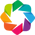

:Overlay
   .Image.I     :Image   [lon,lat]   (air_temperature_at_2_metres)
   .Coastline.I :Feature   [Longitude,Latitude]

In [11]:
holoviews.extension("bokeh")

dataset_plot = gvDataset(ds_surface_temp_2m.isel(time0=0))  # select the first time step

# create the image
images = dataset_plot.to(
    gvImage, ["longitude", "latitude"], ["air_temperature_at_2_metres"], "hour"
)

# aesthetics, add coastlines etc.
images.opts(
    cmap="coolwarm",
    colorbar=True,
    width=600,
    height=400,
    projection=ccrs.PlateCarree(),
    clabel="2m Air Temperature [K]",
) * gf.coastline

In the above figure, coastlines are shown as black lines. Most of the selected region is land, with some ocean (lower left) and a lake (top middle).

Next, we will examine variability at two different frequencies using interactive plots:

1. **Hourly variability** 
2. **Daily variability** 

Note that in the previous tutorial you computed the monthly variability, or *climatology*, but here you only have one month of data loaded (March 2018). If you are curious about longer timescales you will visit this in the next tutorial!

In [12]:
# interactive plot of hourly frequency of surface temperature
# this cell may take a little longer as it contains several maps in a single plotting function
ds_surface_temp_2m_hour = ds_surface_temp_2m.groupby("time0.hour").mean()
dataset_plot = gvDataset(
    ds_surface_temp_2m_hour.isel(hour=slice(0, 12))
)  # only the first 12 time steps, as it is a time consuming task
images = dataset_plot.to(
    gvImage, ["longitude", "latitude"], ["air_temperature_at_2_metres"], "hour"
)
images.opts(
    cmap="coolwarm",
    colorbar=True,
    width=600,
    height=400,
    projection=ccrs.PlateCarree(),
    clabel="2m Air Temperature [K]",
) * gf.coastline

:HoloMap   [hour]
   :Overlay
      .Image.I     :Image   [lon,lat]   (air_temperature_at_2_metres)
      .Coastline.I :Feature   [Longitude,Latitude]

In [13]:
# interactive plot of hourly frequency of surface temperature
# this cell may take a little longer as it contains several maps in a single plotting function holoviews.extension('bokeh')
ds_surface_temp_2m_day = ds_surface_temp_2m.groupby("time0.day").mean()
dataset_plot = gvDataset(
    ds_surface_temp_2m_day.isel(day=slice(0, 10))
)  # only the first 10 time steps, as it is a time consuming task
images = dataset_plot.to(
    gvImage, ["longitude", "latitude"], ["air_temperature_at_2_metres"], "day"
)
images.opts(
    cmap="coolwarm",
    colorbar=True,
    width=600,
    height=400,
    projection=ccrs.PlateCarree(),
    clabel="Air Temperature [K]",
) * gf.coastline

:HoloMap   [day]
   :Overlay
      .Image.I     :Image   [lon,lat]   (air_temperature_at_2_metres)
      .Coastline.I :Feature   [Longitude,Latitude]

### Question 2
1. What differences do you notice between the hourly and daily interactive plots, and are there any interesting spatial patterns of these temperature changes?

In [14]:
# to_remove explanation

"""
1. On hourly timescales, the largest changes are over land because it responds faster than the ocean to the diurnal cycle of solar radiation. This is because the ocean has a higher heat capacity than the land surface. On daily timescales, the surface atmospheric temperature shows comparable variations across both the ocean and land.
""";

# Section 3: Plotting Timeseries of Reanalysis Data

## Section 3.1: Surface Air Temperature Timeseries

You have demonstrated that there are a lot of changes in surface temperature within a day and between days. It is crucial to understand this *temporal variability* in the data when performing climate analysis.

Rather than plotting interactive spatial maps for different timescales, in this last section you will create a timeseries of surface air temperature from the data you have already examined to look at variability on longer than daily timescales. Instead of taking the mean in ***time*** to create *maps*, you will now take the mean in ***space*** to create *timeseries*.

*Note that the spatially-averaged data will now only have a time coordinate coordinate, making it a timeseries (ts).*

In [15]:
# find weights (this is a regular grid so we can use cos(lat))
weights = np.cos(np.deg2rad(ds_surface_temp_2m.lat))
weights.name = "weights"

# take the weighted spatial mean since the latitude range of the region of interest is large
ds_surface_temp_2m_ts = ds_surface_temp_2m.weighted(weights).mean(["lon", "lat"])
ds_surface_temp_2m_ts

<xarray.DataArray 'air_temperature_at_2_metres' (time0: 744)>
array([279.5001 , 279.35767, 278.87677, 278.5952 , 278.49432, 277.9675 ,
       277.86908, 277.75427, 277.41373, 277.45053, 277.05713, 277.0686 ,
       277.06863, 277.2216 , 278.12436, 278.70013, 279.0522 , 280.06696,
       280.2836 , 280.44287, 280.59558, 280.39676, 279.39044, 279.1279 ,
       278.8426 , 278.65915, 278.00055, 277.58322, 277.45718, 276.92526,
       276.7492 , 276.52008, 276.10678, 275.77393, 275.05627, 274.90598,
       274.7608 , 274.73077, 275.68567, 276.36685, 276.8352 , 278.11157,
       278.43033, 278.62323, 278.90982, 278.89868, 278.06982, 277.66443,
       277.0821 , 276.64908, 276.06064, 275.52676, 275.2958 , 274.76395,
       274.62082, 274.43384, 273.98157, 273.8111 , 273.49487, 273.4361 ,
       273.416  , 273.59146, 274.8614 , 275.99463, 276.6748 , 278.1274 ,
       278.57687, 278.91492, 279.29205, 279.4062 , 278.50934, 278.07718,
       277.4959 , 277.12634, 276.23624, 275.6013 , 275.36816, 274.7143 ,
       274.5017 , 274.2349 , 273.78662, 273.63855, 273.0742 , 272.99597,
       272.9988 , 273.23325, 274.51315, 275.6349 , 276.2901 , 277.5388 ,
       277.97324, 278.28403, 278.63364, 278.7007 , 277.75153, 277.24136,
       276.67795, 276.26294, 275.45438, 274.93088, 274.68942, 274.1127 ,
       273.90347, 273.73663, 273.22888, 273.00787, 272.7534 , 272.70288,
       272.62848, 272.95895, 274.08832, 274.98087, 275.5735 , 276.76312,
       277.19974, 277.50092, 277.91464, 277.99585, 277.22214, 276.85812,
...
       277.63348, 277.54462, 277.16476, 277.0474 , 277.23807, 277.24103,
       277.46927, 277.94537, 279.27704, 279.8973 , 280.28574, 281.06635,
       281.294  , 281.49167, 281.672  , 281.81036, 281.1632 , 280.96744,
       280.8162 , 280.57697, 280.06226, 279.81845, 279.71075, 279.29214,
       279.19946, 279.11133, 278.81693, 278.73215, 278.4128 , 278.40906,
       278.53253, 278.9501 , 279.9955 , 280.89883, 281.40936, 282.273  ,
       282.6588 , 282.94028, 283.19858, 283.30576, 282.6813 , 282.4537 ,
       282.11212, 281.9709 , 281.3771 , 281.10385, 280.971  , 280.57086,
       280.4525 , 280.31818, 279.90744, 279.77197, 279.5315 , 279.35675,
       279.58307, 279.9867 , 281.25525, 281.94757, 282.2821 , 283.08633,
       283.35034, 283.50427, 283.464  , 283.43115, 282.25916, 281.9713 ,
       281.6389 , 281.38873, 280.64902, 280.30243, 280.2018 , 279.6712 ,
       279.52374, 279.3781 , 278.93982, 278.70587, 278.2028 , 278.13675,
       278.0354 , 278.1792 , 279.06662, 279.53296, 279.84473, 280.54846,
       280.746  , 280.85605, 280.98886, 280.94135, 280.08044, 279.74182,
       279.2024 , 278.83017, 277.71338, 276.93417, 276.721  , 275.74506,
       275.3823 , 275.1159 , 274.30908, 274.08002, 273.85522, 273.74496,
       273.8333 , 274.53848, 276.67282, 277.84833, 278.36862, 279.49005,
       279.7978 , 280.03284, 280.3925 , 280.5225 , 279.65652, 279.33487],
      dtype=float32)
Coordinates:
  * time0    (time0) datetime64[ns] 2018-03-01 ... 2018-03-31T23:00:00

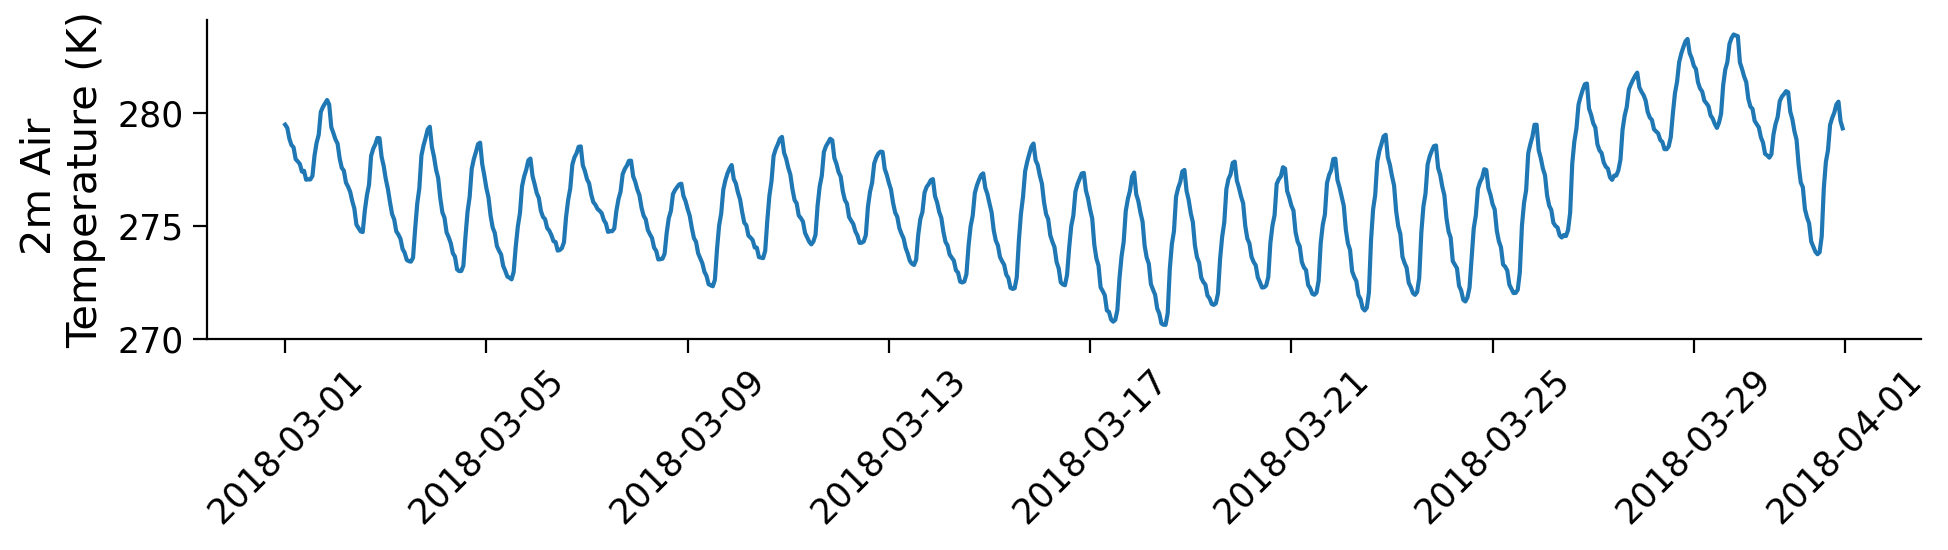

In [16]:
# plot the timeseries of surface temperature

fig, ax = plt.subplots(1, 1, figsize=(10, 3))

ax.plot(ds_surface_temp_2m_ts.time0, ds_surface_temp_2m_ts)
ax.set_ylabel("2m Air \nTemperature (K)")
ax.xaxis.set_tick_params(rotation=45)

### Questions 3.1
1. What is the dominant source of the high frequency (short timescale) variability? 
2. What drives the lower frequency variability? 
3. Would the ENSO variablity that you computed in the previous tutorial show up here? Why or why not?

In [17]:
# to_remove explanation
"""
1. The high frequency variability can largely be attributed to the diurnal cycle, or the differences in solar radiation between night and day. This causes large variations in surface temperature, particularly over land and shallow water.
2. The low frequency variability can be attributed to synoptic patterns (e.g., weather) which can move cold or warm air around on timescales of days to weeks.
3. We do not have a long enough time series for ENSO to show up, but ENSO could indirectly affect this timeseries by changing weather patterns on shorter timescales.
""";

## Section 3.2: Comparing Timeseries of Multiple Variables

Below you will calculate the timeseries of the surface air temperature which we just plotted, alongside timeseries of several other ERA5 variables for the same period and region: 10-meter wind speed, atmospheric surface pressure, and sea surface temperature. 

In [18]:
ERA5_allvars_ts = ERA5_allvars.weighted(weights).mean(["lon", "lat"])

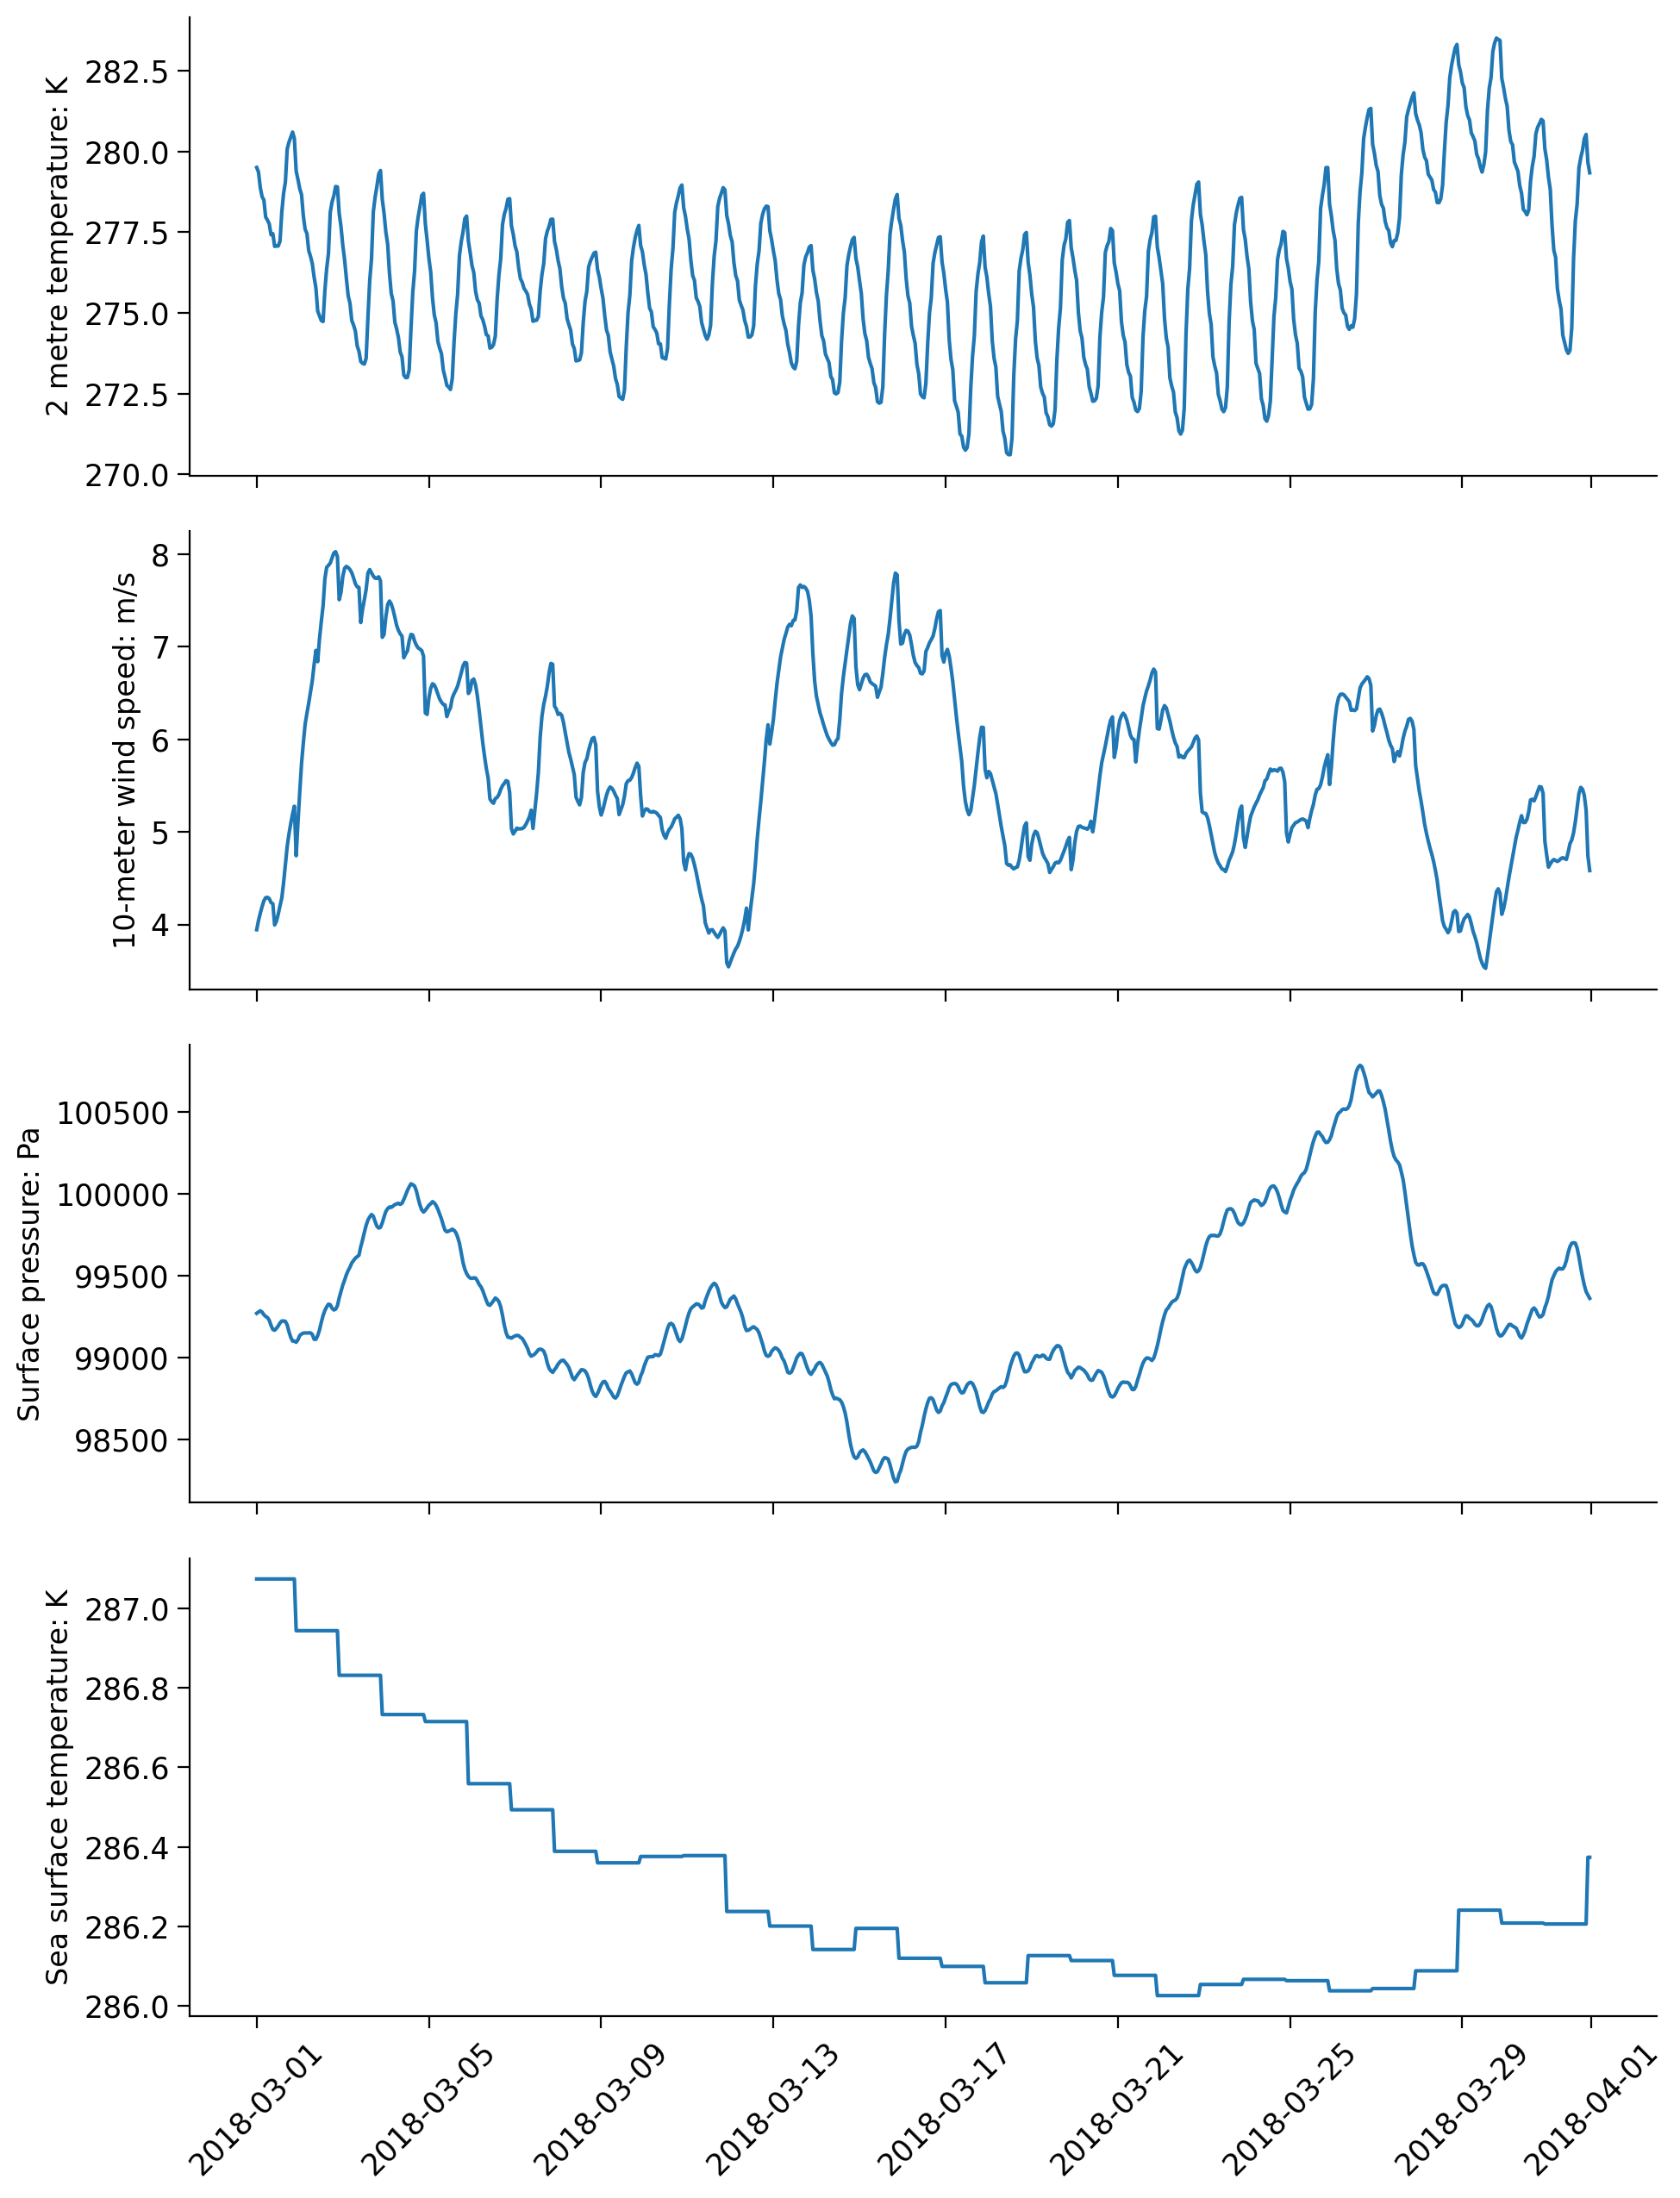

In [19]:
plot_vars = [
    "air_temperature_at_2_metres",
    "wind_speed",
    "surface_air_pressure",
    "sea_surface_temperature",
]

fig, ax_list = plt.subplots(len(plot_vars), 1, figsize=(10, 13), sharex=True)

for var, ax in zip(plot_vars, ax_list):

    ax.plot(ERA5_allvars_ts.time0, ERA5_allvars_ts[var])
    ax.set_ylabel(
        ERA5_allvars[var].attrs["long_name"] + ": " + ERA5_allvars[var].attrs["units"],
        fontsize=12,
    )
    ax.xaxis.set_tick_params(rotation=45)

### Questions 3.2

Which variable shows variability that is dominated by:
1. The diurnal cycle?
2. The synoptic [~5 day] scale?
3. A mix of these two timescales?
4. Longer timescales?

In [20]:
# to_remove explanation
"""
1. The 2-meter temperature is dominated by the diurnal cycle.
2. The surface pressure, which is usually associated with storms, is dominated by the synoptic scale.
3. The 10-meter wind speed shows influences from both the diurnal cycle and the synoptic scale.
4. The ocean surface temperature shows some sensitivity to the diurnal cycle but is dominated by longer timescale (>weeks) variations than the atmospheric variables.
""";

## Bonus Section 1: Selecting a Different Spatial Region

Define another spatial region, such as where you live, by selecting a longitude and latitude range of of your choosing. To find the longitude and latitude coordinates of your region, you can use [Google Earth view](https://earth.google.com/), and read the position of your cursor in the lower right corner.

### Bonus Section 1.1: Note About the Geographic Coordinate System and the Coordinates Used in This Dataset
A point on Earth is described by latitude-longitude coordinates relative to the zero-meridian line going through Greenwich in London, UK (longitude = 0 degree) and the xero-latitude line along the equator (latitude = 0 degrees). Points east of Greenwich up to the *dateline* on the opposite side of the globe are referenced as 0 to +180 and points to the west of Greenwich are 0 to -180. -180 and +180 refer to the same longitude, the so-called *dateline* in the central pacific. 

However, our data is referenced in a slightly different way where longitude runs from 0 to 360 rather than -180 to +180. Longitude increases as you move east of Greenwich, until you reach Greenwich again (0 or 360 degrees), rather than stopping at the *dateline*. 

# Summary

In this tutorial, you learned how to access and process ERA5 reanalysis data. You are able to select specific regions within the reanalysis dataset and perform operations such as taking spatial and temporal averages.

You also looked at different climate variables to distinguish idenitfy the variability present at different timescales.


# Resources

Data for this tutorial can be accessed [here](https://registry.opendata.aws/ecmwf-era5/).